In [ ]:
# Import all required libraries for data handling, model training, evaluation, and visualization
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForTokenClassification
from transformers import get_linear_schedule_with_warmup
# Use AdamW optimizer for better performance with transformers
from torch.optim import AdamW 
from datasets import load_dataset
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report as seqeval_report
import warnings
import sys
import subprocess

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

c:\Users\Quique\anaconda3\envs\TFG\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
# Set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Using device: cuda


In [ ]:
# Load the JNLPBA biomedical NER dataset from HuggingFace Datasets
print("\n Loading JNLPBA Biomedical Dataset...")
print("Using 'commanderstrife/jnlpba'")

try:
    dataset = load_dataset("commanderstrife/jnlpba", "jnlpba")
except Exception as e:
    print(f"Error loading dataset: {e}")
    sys.exit()

# Print dataset splits and sample counts
print(f"\nDataset splits: {list(dataset.keys())}")
print(f"Training samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

# Show the structure of a sample example
print("\n First training example:")
example = dataset['train'][0]
print(f"Tokens (first 10): {example['tokens'][:10]}")
print(f"NER tags (first 10): {example['ner_tags'][:10]}")


 Loading JNLPBA Biomedical Dataset...
Using 'commanderstrife/jnlpba'

Dataset splits: ['train', 'validation', 'test']
Training samples: 37094
Validation samples: 7714
Test samples: 7714

 First training example:
Tokens (first 10): ['IL-2', 'gene', 'expression', 'and', 'NF-kappa', 'B', 'activation', 'through', 'CD28', 'requires']
NER tags (first 10): [7, 8, 0, 0, 15, 16, 0, 0, 15, 0]


In [ ]:
# Extract and map label names from the dataset for NER task
try:
    tag_names = dataset["train"].features["ner_tags"].feature.names
    print(f"Labels loaded from dataset ({len(tag_names)}):")
    print(tag_names)
except NameError:
    print("Error: 'dataset' not defined. Run cell 3 first.")
    raise

# Create mappings from tag to index and vice versa (no 'X' label, use -100 for ignored tokens)
tag2idx = {tag: idx for idx, tag in enumerate(tag_names)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

NUM_LABELS = len(tag2idx)
print(f"\nNumber of unique tags: {NUM_LABELS}")
print(f"Labels: {list(tag2idx.keys())}")

Labels loaded from dataset (19):
['O', 'B-GENE', 'I-GENE', 'B-CHEMICAL', 'I-CHEMICAL', 'B-DISEASE', 'I-DISEASE', 'B-DNA', 'I-DNA', 'B-RNA', 'I-RNA', 'B-CELL_LINE', 'I-CELL_LINE', 'B-CELL_TYPE', 'I-CELL_TYPE', 'B-PROTEIN', 'I-PROTEIN', 'B-SPECIES', 'I-SPECIES']

Number of unique tags: 19
Labels: ['O', 'B-GENE', 'I-GENE', 'B-CHEMICAL', 'I-CHEMICAL', 'B-DISEASE', 'I-DISEASE', 'B-DNA', 'I-DNA', 'B-RNA', 'I-RNA', 'B-CELL_LINE', 'I-CELL_LINE', 'B-CELL_TYPE', 'I-CELL_TYPE', 'B-PROTEIN', 'I-PROTEIN', 'B-SPECIES', 'I-SPECIES']


In [ ]:
# Initialize the BioBERT tokenizer for the chosen model
print(f"\n Initializing BioBERT tokenizer...")
model_name = "dmis-lab/biobert-v1.1"
tokenizer = BertTokenizer.from_pretrained(model_name)


 Initializing BioBERT tokenizer...


In [ ]:
# Custom Dataset class for JNLPBA NER task
class JNLPBADataset(Dataset):
    def __init__(self, dataset_split, tokenizer, tag2idx, max_len=128):
        self.dataset = dataset_split
        self.tokenizer = tokenizer
        self.tag2idx = tag2idx
        self.max_len = max_len
        
        # Get original label names from dataset
        self.original_tag_names = dataset_split.features["ner_tags"].feature.names
        
        # Create mapping: original_index -> new_index (or -100 if invalid)
        self.remap = {}
        for orig_idx, tag_name in enumerate(self.original_tag_names):
            if tag_name in self.tag2idx:
                self.remap[orig_idx] = self.tag2idx[tag_name]
            else:
                self.remap[orig_idx] = -100  # Ignore invalid labels
        
        print(f"  Remapping created: {len([v for v in self.remap.values() if v != -100])} valid labels")

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieve a single example and process it for BioBERT input
        example = self.dataset[idx]
        words = example['tokens']
        original_tags = example['ner_tags']

        encoded_sentence = []
        encoded_tags_ids = []

        # For each word and its original tag, tokenize the word and assign tags to subtokens
        for word, orig_tag_idx in zip(words, original_tags):
            word_tokens = self.tokenizer.tokenize(str(word))
            
            if len(word_tokens) == 0:
                word_tokens = [self.tokenizer.unk_token]
            
            encoded_sentence.extend(word_tokens)
            
            # Remap original index -> new index
            new_tag_idx = self.remap.get(orig_tag_idx, -100)
            
            # First subtoken: remapped label, rest: -100 (ignored by loss)
            encoded_tags_ids.extend([new_tag_idx] + [-100] * (len(word_tokens) - 1))

        # Add [CLS] and [SEP] special tokens
        encoded_sentence = [self.tokenizer.cls_token] + encoded_sentence + [self.tokenizer.sep_token]
        encoded_tags_ids = [-100] + encoded_tags_ids + [-100]

        input_ids = self.tokenizer.convert_tokens_to_ids(encoded_sentence)
        attention_mask = [1] * len(input_ids)

        # Pad or truncate sequences to the maximum length
        if len(input_ids) < self.max_len:
            pad_len = self.max_len - len(input_ids)
            input_ids.extend([self.tokenizer.pad_token_id] * pad_len)
            attention_mask.extend([0] * pad_len)
            encoded_tags_ids.extend([-100] * pad_len)
        else:
            input_ids = input_ids[:self.max_len]
            attention_mask = attention_mask[:self.max_len]
            encoded_tags_ids = encoded_tags_ids[:self.max_len]

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(encoded_tags_ids, dtype=torch.long)
        }

In [ ]:
# Create PyTorch datasets and dataloaders for training, validation, and testing
print("\n Creating datasets and dataloaders...")
MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = JNLPBADataset(dataset['train'], tokenizer, tag2idx, max_len=MAX_LEN)
val_dataset = JNLPBADataset(dataset['validation'], tokenizer, tag2idx, max_len=MAX_LEN)
test_dataset = JNLPBADataset(dataset['test'], tokenizer, tag2idx, max_len=MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✓ Training batches: {len(train_dataloader)}")
print(f"✓ Validation batches: {len(val_dataloader)}")
print(f"✓ Test batches: {len(test_dataloader)}")


 Creating datasets and dataloaders...
  Remapping created: 19 valid labels
  Remapping created: 19 valid labels
  Remapping created: 19 valid labels
✓ Training batches: 2319
✓ Validation batches: 483
✓ Test batches: 483


In [ ]:
# Initialize BioBERT model for token classification task
print(f"\n Initializing BioBERT for token classification...")
print(f"Number of labels: {NUM_LABELS}")

model = BertForTokenClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    output_attentions=False,
    output_hidden_states=False
)
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"  Total parameters: {total_params:,}")


 Initializing BioBERT for token classification...
Number of labels: 19


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Total parameters: 107,734,291


In [ ]:
# Set training hyperparameters and optimizer
LEARNING_RATE = 2e-5
EPOCHS = 5 # The tutorial uses 1 
warmup_steps = 0

print(f"\n Training Configuration:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Set up learning rate scheduler for gradual warmup and decay
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)


 Training Configuration:
  Learning rate: 2e-05
  Batch size: 16
  Epochs: 5


In [ ]:
# Training function for BioBERT NER model
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs, idx2tag_map):
    training_stats = []
    best_val_f1 = 0
    
    for epoch in range(epochs):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{epochs}")
        print('='*50)
        
        print(' Training...')
        model.train()
        total_train_loss = 0
        train_steps = 0
        
        progress_bar = tqdm(train_dataloader, desc="Training", leave=True)
        
        for batch in progress_bar:
            model.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            if loss is None:
                continue
                
            total_train_loss += loss.item()
            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            scheduler.step()
            train_steps += 1
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        avg_train_loss = total_train_loss / train_steps
        print(f" Average training loss: {avg_train_loss:.4f}")
        
        print(' Evaluating...')
        model.eval()
        total_val_loss = 0
        val_steps = 0
        true_labels = []
        pred_labels = []
        
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Validation", leave=True):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                if outputs.loss is not None:
                    total_val_loss += outputs.loss.item()
                
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=2)
                
                for i in range(input_ids.shape[0]):
                    true_sentence = []
                    pred_sentence = []
                    
                    for j in range(labels.shape[1]):
                        label_id = labels[i][j].item()
                        
                        # Only process valid labels (not -100)
                        if label_id != -100:
                            pred_id = predictions[i][j].item()
                            
                            true_tag = idx2tag_map.get(label_id, 'O')
                            pred_tag = idx2tag_map.get(pred_id, 'O')
                            
                            true_sentence.append(true_tag)
                            pred_sentence.append(pred_tag)
                    
                    if true_sentence:
                        true_labels.append(true_sentence)
                        pred_labels.append(pred_sentence)
                
                val_steps += 1
        
        avg_val_loss = total_val_loss / val_steps
        val_f1 = f1_score(true_labels, pred_labels, zero_division=0)
        val_precision = precision_score(true_labels, pred_labels, zero_division=0)
        val_recall = recall_score(true_labels, pred_labels, zero_division=0)
        
        print(f" Average validation loss: {avg_val_loss:.4f}")
        print(f" Validation F1 Score: {val_f1:.4f}")
        print(f" Validation Precision: {val_precision:.4f}")
        print(f" Validation Recall: {val_recall:.4f}")
        
        # Save the best model based on validation F1 score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            print(f" New best F1: {best_val_f1:.4f}. Saving...")
            torch.save(model.state_dict(), "biobert_jnlpba_best.pt")
        
        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_f1': val_f1,
            'val_precision': val_precision,
            'val_recall': val_recall
        })
    
    return training_stats

In [ ]:
# Start the fine-tuning process for BioBERT on JNLPBA dataset
print("\n Starting BioBERT fine-tuning for JNLPBA...")
training_stats = train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, EPOCHS, idx2tag)
print("\n Training completed!")


 Starting BioBERT fine-tuning for JNLPBA...

Epoch 1/5
 Training...


Training:   0%|          | 0/2319 [00:00<?, ?it/s]

 Average training loss: 0.1781
 Evaluating...


Validation:   0%|          | 0/483 [00:00<?, ?it/s]

 Average validation loss: 0.1914
 Validation F1 Score: 0.7422
 Validation Precision: 0.6877
 Validation Recall: 0.8060
 New best F1: 0.7422. Saving...

Epoch 2/5
 Training...


Training:   0%|          | 0/2319 [00:00<?, ?it/s]

 Average training loss: 0.0966
 Evaluating...


Validation:   0%|          | 0/483 [00:00<?, ?it/s]

 Average validation loss: 0.2084
 Validation F1 Score: 0.7419
 Validation Precision: 0.6939
 Validation Recall: 0.7970

Epoch 3/5
 Training...


Training:   0%|          | 0/2319 [00:00<?, ?it/s]

 Average training loss: 0.0628
 Evaluating...


Validation:   0%|          | 0/483 [00:00<?, ?it/s]

 Average validation loss: 0.2649
 Validation F1 Score: 0.7318
 Validation Precision: 0.6872
 Validation Recall: 0.7826

Epoch 4/5
 Training...


Training:   0%|          | 0/2319 [00:00<?, ?it/s]

 Average training loss: 0.0411
 Evaluating...


Validation:   0%|          | 0/483 [00:00<?, ?it/s]

 Average validation loss: 0.3039
 Validation F1 Score: 0.7320
 Validation Precision: 0.6883
 Validation Recall: 0.7817

Epoch 5/5
 Training...


Training:   0%|          | 0/2319 [00:00<?, ?it/s]

 Average training loss: 0.0291
 Evaluating...


Validation:   0%|          | 0/483 [00:00<?, ?it/s]

 Average validation loss: 0.3281
 Validation F1 Score: 0.7320
 Validation Precision: 0.6876
 Validation Recall: 0.7825

 Training completed!


In [ ]:
# Function to evaluate the trained model on a given dataloader
def evaluate_model(model, dataloader, idx2tag_map):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=2)
            
            for i in range(input_ids.shape[0]):
                true_sentence = []
                pred_sentence = []
                
                for j in range(labels.shape[1]):
                    label_id = labels[i][j].item()
                    
                    if label_id != -100:
                        pred_id = predictions[i][j].item()
                        
                        true_tag = idx2tag_map.get(label_id, 'O')
                        pred_tag = idx2tag_map.get(pred_id, 'O')
                        
                        true_sentence.append(true_tag)
                        pred_sentence.append(pred_tag)
                
                if true_sentence:
                    y_true.append(true_sentence)
                    y_pred.append(pred_sentence)
    
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    print(f"\nTest Results:")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    
    report = seqeval_report(y_true, y_pred)
    print("\nDetailed Report:")
    print(report)
    
    return f1, precision, recall, report

In [ ]:
# Predict biomedical entities in a given sentence using the trained model
def predict_biomedical_entities(text, model, tokenizer, idx2tag_map):
    tokens = text.split()
    bert_tokens = []
    orig_to_bert_map = []
    
    for token in tokens:
        orig_to_bert_map.append(len(bert_tokens) + 1)  # +1 for [CLS]
        subwords = tokenizer.tokenize(token)
        if len(subwords) == 0:
            subwords = ['[UNK]']
        bert_tokens.extend(subwords)
    
    bert_tokens = ['[CLS]'] + bert_tokens + ['[SEP]']
    input_ids = tokenizer.convert_tokens_to_ids(bert_tokens)
    attention_mask = [1] * len(input_ids)
    
    # Padding to MAX_LEN
    padding_length = MAX_LEN - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + ([tokenizer.pad_token_id] * padding_length)
        attention_mask = attention_mask + ([0] * padding_length)
    else:
        input_ids = input_ids[:MAX_LEN]
        attention_mask = attention_mask[:MAX_LEN]
    
    input_ids = torch.tensor([input_ids]).to(device)
    attention_mask = torch.tensor([attention_mask]).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=2)
    
    pred_tags = [idx2tag_map[p.item()] for p in predictions[0]]
    
    result = []
    for i, token in enumerate(tokens):
        if i < len(orig_to_bert_map):
            bert_idx = orig_to_bert_map[i]
            if bert_idx < len(pred_tags):
                pred_tag = pred_tags[bert_idx]
                if pred_tag != 'O':  # Only return entities
                    result.append((token, pred_tag))
    
    return result

In [ ]:
# Load the best saved model and evaluate on the test set
print("Loading best saved model...")
model.load_state_dict(torch.load("biobert_jnlpba_best.pt"))
model.to(device)

print("Evaluating on TEST set...")
f1, precision, recall, report = evaluate_model(model, test_dataloader, idx2tag)

print("\n Testing on biomedical sentences:")

# Example biomedical sentences for entity prediction
biomedical_examples = [
    "The p53 protein regulates DNA repair mechanisms.",
    "Expression of BRCA1 and BRCA2 was measured in MCF-7 cell lines.",
    "IL-2 receptor phosphorylation in T cells was observed.",
]

for sentence in biomedical_examples:
    print(f"\n Sentence: {sentence}")
    entities = predict_biomedical_entities(sentence, model, tokenizer, idx2tag)
    if entities:
        print(" Predicted entities:")
        for entity, tag in entities:
            print(f"   - {entity}: {tag}")
    else:
        print("   No entities detected")

Loading best saved model...
Evaluating on TEST set...


Evaluating:   0%|          | 0/483 [00:00<?, ?it/s]


Test Results:
  F1 Score: 0.7422
  Precision: 0.6877
  Recall: 0.8060

Detailed Report:
              precision    recall  f1-score   support

   CELL_LINE       0.56      0.68      0.61      1000
   CELL_TYPE       0.77      0.74      0.75      3840
         DNA       0.69      0.79      0.74      2108
     PROTEIN       0.68      0.85      0.75     10114
         RNA       0.65      0.75      0.70       236

   micro avg       0.69      0.81      0.74     17298
   macro avg       0.67      0.76      0.71     17298
weighted avg       0.69      0.81      0.74     17298


 Testing on biomedical sentences:

 Sentence: The p53 protein regulates DNA repair mechanisms.
 Predicted entities:
   - p53: B-PROTEIN
   - protein: I-PROTEIN

 Sentence: Expression of BRCA1 and BRCA2 was measured in MCF-7 cell lines.
 Predicted entities:
   - BRCA1: B-DNA
   - BRCA2: B-DNA
   - MCF-7: B-CELL_LINE
   - cell: I-CELL_LINE
   - lines.: I-CELL_LINE

 Sentence: IL-2 receptor phosphorylation in T cells was

#    ANÁLISIS DE OVERFITTING 

 Saved: Imagenes/BioBERT\BioBERT_Loss_Curves.png


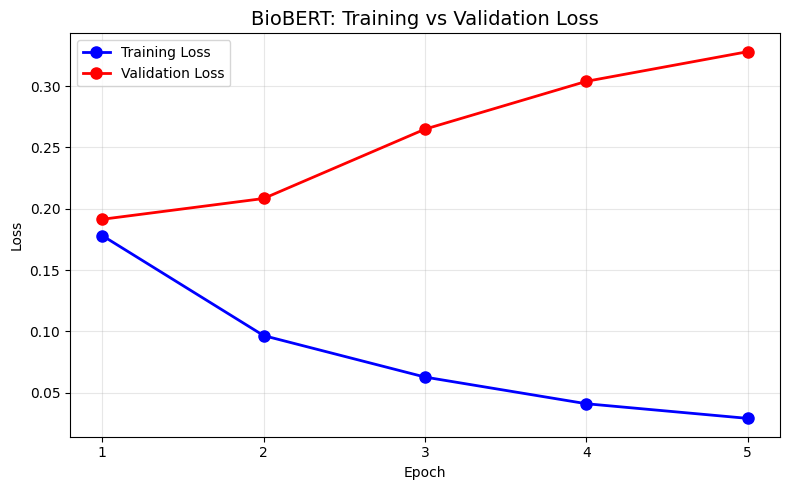

 Saved: Imagenes/BioBERT\BioBERT_F1_Curves.png


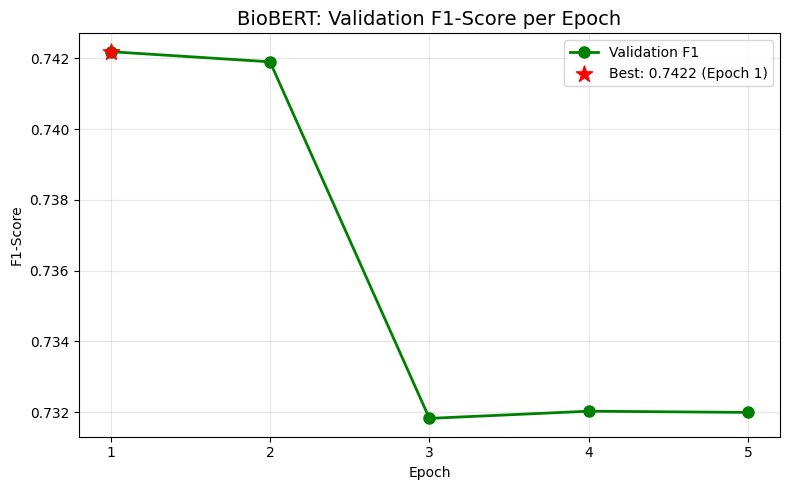


 Files in 'Imagenes/BioBERT':
   - BioBERT_F1_Curves.png
   - BioBERT_Loss_Curves.png

 Summary:
   Best epoch: 1 with F1 = 0.7422
   Final F1: 0.7320


In [ ]:
# Plot training and validation loss and F1-score curves, and save the figures
import matplotlib.pyplot as plt
import pandas as pd
import os

MODEL_NAME = "BioBERT"
save_folder = 'Imagenes/BioBERT'

os.makedirs(save_folder, exist_ok=True)

# Convert training statistics to DataFrame for plotting
df_stats = pd.DataFrame(training_stats)

# Plot 1: Training vs Validation Loss
fig1, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(df_stats['epoch'], df_stats['train_loss'], 'b-o', 
         linewidth=2, markersize=8, label='Training Loss')
ax1.plot(df_stats['epoch'], df_stats['val_loss'], 'r-o', 
         linewidth=2, markersize=8, label='Validation Loss')
ax1.set_title(f'{MODEL_NAME}: Training vs Validation Loss', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(df_stats['epoch'])

plt.tight_layout()
save_path_1 = os.path.join(save_folder, f'{MODEL_NAME}_Loss_Curves.png')
fig1.savefig(save_path_1, dpi=300, bbox_inches='tight')
print(f" Saved: {save_path_1}")
plt.show()

# Plot 2: Validation F1-Score per Epoch
fig2, ax2 = plt.subplots(figsize=(8, 5))

ax2.plot(df_stats['epoch'], df_stats['val_f1'], 'g-o', 
         linewidth=2, markersize=8, label='Validation F1')

best_idx = df_stats['val_f1'].idxmax()
best_f1 = df_stats['val_f1'][best_idx]
best_epoch = df_stats['epoch'][best_idx]
ax2.scatter([best_epoch], [best_f1], color='red', s=150, zorder=5, 
            marker='*', label=f'Best: {best_f1:.4f} (Epoch {best_epoch})')

ax2.set_title(f'{MODEL_NAME}: Validation F1-Score per Epoch', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-Score')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(df_stats['epoch'])

plt.tight_layout()
save_path_2 = os.path.join(save_folder, f'{MODEL_NAME}_F1_Curves.png')
fig2.savefig(save_path_2, dpi=300, bbox_inches='tight')
print(f" Saved: {save_path_2}")
plt.show()

print(f"\n Files in '{save_folder}':")
for f in os.listdir(save_folder):
    print(f"   - {f}")

print(f"\n Summary:")
print(f"   Best epoch: {best_epoch} with F1 = {best_f1:.4f}")
print(f"   Final F1: {df_stats['val_f1'].iloc[-1]:.4f}")

#   MATRIZ DE CONFUSIÓN (BIO BERT - Entity Level)

Generating final plots for BioBERT...
Calculating metrics...
Results: Train F1: 0.978 | Test F1: 0.732
 Saved: Imagenes/BioBERT/BioBERT_Overfitting.png


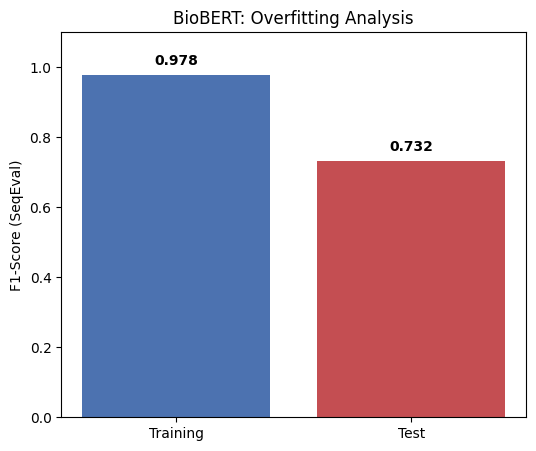

Generating confusion matrix...
Entities: ['CELL_LINE', 'CELL_TYPE', 'DNA', 'O', 'PROTEIN', 'RNA']
 Saved: Imagenes/BioBERT/BioBERT_Confusion_Matrix.png


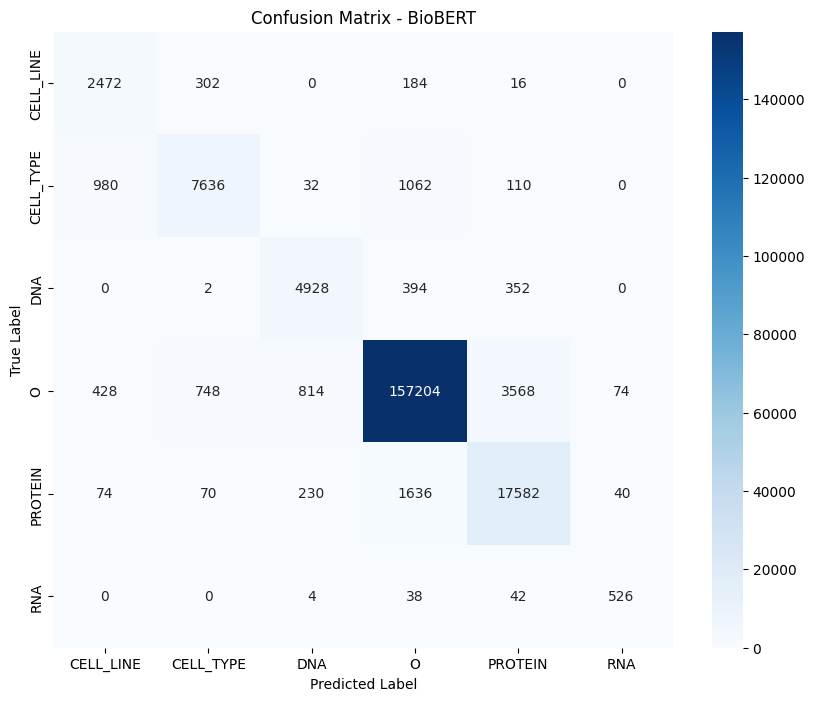


 Files in 'Imagenes/BioBERT':
   - BioBERT_Confusion_Matrix.png
   - BioBERT_F1_Curves.png
   - BioBERT_Loss_Curves.png
   - BioBERT_Overfitting.png


In [ ]:
# Generate final plots: overfitting analysis and confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
from seqeval.metrics import f1_score
import os

MODEL_NAME = "BioBERT"
save_folder = 'Imagenes/BioBERT'

os.makedirs(save_folder, exist_ok=True)

print(f"Generating final plots for {MODEL_NAME}...")

# Helper function to get predictions for all samples in a dataloader
def get_predictions(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=2)
            
            for i in range(input_ids.shape[0]):
                p_sent = []
                t_sent = []
                
                for j in range(len(labels[i])):
                    label_id = labels[i][j].item()
                    pred_id = predictions[i][j].item()
                    
                    if label_id != -100:
                        t_tag_str = idx2tag[label_id]
                        p_tag_str = idx2tag[pred_id]
                        t_sent.append(t_tag_str)
                        p_sent.append(p_tag_str)
                
                if t_sent:
                    y_true.append(t_sent)
                    y_pred.append(p_sent)
    return y_true, y_pred

print("Calculating metrics...")

# Get predictions for train and test sets
y_tr_true, y_tr_pred = get_predictions(model, train_dataloader) 
y_te_true, y_te_pred = get_predictions(model, test_dataloader)

# Calculate F1-scores using seqeval
f1_train = f1_score(y_tr_true, y_tr_pred)
f1_test = f1_score(y_te_true, y_te_pred)

print(f"Results: Train F1: {f1_train:.3f} | Test F1: {f1_test:.3f}")

# Overfitting plot
fig1, ax1 = plt.subplots(figsize=(6, 5))
bars = ax1.bar(['Training', 'Test'], [f1_train, f1_test], color=['#4c72b0', '#c44e52'])
ax1.set_ylim(0, 1.1)
ax1.set_title(f'{MODEL_NAME}: Overfitting Analysis')
ax1.set_ylabel('F1-Score (SeqEval)')

for bar in bars:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontweight='bold')

fig1.savefig(f'{save_folder}/{MODEL_NAME}_Overfitting.png', dpi=300, bbox_inches='tight')
print(f" Saved: {save_folder}/{MODEL_NAME}_Overfitting.png")
plt.show()

# Confusion Matrix
print("Generating confusion matrix...")

# Flatten lists and remove BIO prefixes (B-DNA -> DNA)
flat_true_raw = [t.split('-')[1] if '-' in t else t for s in y_te_true for t in s]
flat_pred_raw = [t.split('-')[1] if '-' in t else t for s in y_te_pred for t in s]

flat_true = []
flat_pred = []
for t, p in zip(flat_true_raw, flat_pred_raw):
    flat_true.append(t)
    flat_pred.append(p)

labels = sorted(list(set(flat_true + flat_pred)))
print(f"Entities: {labels}")

cm = confusion_matrix(flat_true, flat_pred, labels=labels)

fig2, ax2 = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax2)
ax2.set_title(f'Confusion Matrix - {MODEL_NAME}')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

fig2.savefig(f'{save_folder}/{MODEL_NAME}_Confusion_Matrix.png', dpi=300, bbox_inches='tight')
print(f" Saved: {save_folder}/{MODEL_NAME}_Confusion_Matrix.png")
plt.show()

print(f"\n Files in '{save_folder}':")
for f in os.listdir(save_folder):
    print(f"   - {f}")